In [3]:
import biom
import pandas as pd
import numpy as np
import qiime2 as q2 
from qiime2.plugins import taxa

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss

import statsmodels.regression.mixed_linear_model as sm

In [4]:
from biom import Table
# load biom table and metadata 
thdmi_ft = q2.Artifact.load('../data/filtered_ft.qza')
wol2_tax = q2.Artifact.import_data('FeatureData[Taxonomy]', '/projects/wol/qiyun/wol2/taxonomy/lineages.txt', 'HeaderlessTSVTaxonomyFormat')
thdmi_md = q2.Metadata.load('/projects/thdmi/metadata/consolidated_metadata_subset.tsv').to_dataframe()

In [5]:
thdmi_genus = taxa.methods.collapse(table=thdmi_ft, taxonomy=wol2_tax, level=6).collapsed_table

In [6]:
thdmi_genus_df = thdmi_genus.view(pd.DataFrame)

In [7]:
thdmi_genus_df = thdmi_genus_df.replace(0, np.nan)

In [8]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=3)

# Perform KNN imputation
thdmi_genus_knn = pd.DataFrame(imputer.fit_transform(thdmi_genus_df), columns=thdmi_genus_df.columns, index=thdmi_genus_df.index)

In [9]:
from skbio.stats.composition import clr, multiplicative_replacement

metagenomic_counts = np.array(thdmi_genus_knn)  

# Apply CLR transformation
clr_transformed_data = clr(metagenomic_counts)

thdmi_genus_clr = pd.DataFrame(clr_transformed_data,index=thdmi_genus_knn.index, columns=thdmi_genus_knn.columns)

In [10]:
nutrient_intake = thdmi_md.columns[thdmi_md.columns.str.contains('Percent_of_calories')]
amount = thdmi_md.columns[thdmi_md.columns.str.startswith('Amount_')]
hei_2015 = thdmi_md.columns[thdmi_md.columns.str.startswith('Hei2015')]
collapsed_foods = thdmi_md.columns[thdmi_md.columns.str.startswith('Collapsed_')]
additional_cols = ['DP_All', 'DP_Core', 'types_of_plants_coded', 'diet_type_coded', 'fermented_plant_frequency_coded', 'specialized_diet_exclude_dairy', 
                   'specialized_diet_exclude_refined_sugars', 'Processed_Calories_Nova_processed_foods', 'Processed_Calories_Nova_ultra_processed_foods',
                   'Processed_Grams_Nova_ultra_processed_foods', 'Processed_Grams_Nova_processed_foods', 'Processed_Grams_Nova_unprocessed_or_minimally_processed_foods', 
                   'Processed_Calories_Nova_unprocessed_or_minimally_processed_foods', 'thdmi_cohort', 'covid_level_of_wellbeing_coded', 'bmi_cat_coded',
                   'antibiotic_history_coded', 'sex']

In [11]:
faecali_clr = thdmi_genus_clr['d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Oscillospirales;f__Ruminococcaceae;g__Faecalibacterium']
prevotella_clr = thdmi_genus_clr['d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Prevotella']

In [12]:
thdmi_md_subset = thdmi_md[nutrient_intake.union(amount).union(hei_2015).union(collapsed_foods).union(additional_cols)]

for c in ['Processed_Calories_Nova_processed_foods', 'Processed_Calories_Nova_ultra_processed_foods', 'Processed_Calories_Nova_unprocessed_or_minimally_processed_foods']: 
    thdmi_md_subset.insert(thdmi_md_subset.shape[1], c + '_per1000kcal', thdmi_md_subset[c] * 10)
    thdmi_md_subset[c] = (1/100) * thdmi_md_subset[c] * thdmi_md_subset['Amount_Energy_in_kcal']
    

for g in ['Processed_Grams_Nova_ultra_processed_foods', 'Processed_Grams_Nova_processed_foods', 'Processed_Grams_Nova_unprocessed_or_minimally_processed_foods']: 
    new_col = thdmi_md_subset[g].copy().values
    thdmi_md_subset[g] = (1/100) * thdmi_md_subset[g] * thdmi_md_subset['Amount_Total_Grams_in_g']
    thdmi_md_subset.insert(thdmi_md_subset.shape[1], g.replace('Grams', 'Percent_Grams'), new_col)

thdmi_md_subset = thdmi_md_subset.loc[thdmi_md_subset.index.intersection(thdmi_genus_clr.index)]
thdmi_md_subset.insert(thdmi_md_subset.shape[1], 'faecali_clr', faecali_clr)
thdmi_md_subset.insert(thdmi_md_subset.shape[1], 'prevotella_clr', prevotella_clr)

for c in thdmi_md_subset.columns:
    if '+' in c: 
        thdmi_md_subset.rename(columns={c: c.replace('+', 'and')}, inplace=True) 

/tmp/ipykernel_195098/791283269.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thdmi_md_subset[c] = (1/100) * thdmi_md_subset[c] * thdmi_md_subset['Amount_Energy_in_kcal']
/tmp/ipykernel_195098/791283269.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thdmi_md_subset[c] = (1/100) * thdmi_md_subset[c] * thdmi_md_subset['Amount_Energy_in_kcal']
/tmp/ipykernel_195098/791283269.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

In [13]:
prev_bacteroides_plots = thdmi_md_subset[['thdmi_cohort', 'faecali_clr', 'prevotella_clr', 'DP_All', 'DP_Core']]
prev_bact_mx_excluded = prev_bacteroides_plots.loc[prev_bacteroides_plots['thdmi_cohort'] != 'Mexico']
prev_bact_uk_excluded = prev_bacteroides_plots.loc[prev_bacteroides_plots['thdmi_cohort'] != 'UK']
prev_bact_us_excluded = prev_bacteroides_plots.loc[prev_bacteroides_plots['thdmi_cohort'] != 'US']
prev_bacteroides_melted = prev_bacteroides_plots[['thdmi_cohort', 'faecali_clr', 
                                                  'prevotella_clr']].melt(id_vars=['thdmi_cohort'], var_name='ratio', value_name='log_ratio')

In [14]:
import itertools

In [15]:
print('Faecalibacterium')
print('All') 
print(ss.kruskal(*[g['faecali_clr'].values for n, g in prev_bacteroides_plots.groupby('thdmi_cohort')]))
print('UK vs US:') 
print(ss.kruskal(*[g['faecali_clr'].values for n, g in prev_bact_mx_excluded.groupby('thdmi_cohort')]))
print('MX vs US:') 
print(ss.kruskal(*[g['faecali_clr'].values for n, g in prev_bact_uk_excluded.groupby('thdmi_cohort')]))
print('MX vs UK:') 
print(ss.kruskal(*[g['faecali_clr'].values for n, g in prev_bact_us_excluded.groupby('thdmi_cohort')]))
print()
print('Prevotella')
print('All') 
print(ss.kruskal(*[g['prevotella_clr'].values for n, g in prev_bacteroides_plots.groupby('thdmi_cohort')]))
print('UK vs US:') 
print(ss.kruskal(*[g['prevotella_clr'].values for n, g in prev_bact_mx_excluded.groupby('thdmi_cohort')]))
print('MX vs US:') 
print(ss.kruskal(*[g['prevotella_clr'].values for n, g in prev_bact_uk_excluded.groupby('thdmi_cohort')]))
print('MX vs UK:') 
print(ss.kruskal(*[g['prevotella_clr'].values for n, g in prev_bact_us_excluded.groupby('thdmi_cohort')]))

Faecalibacterium
All
KruskalResult(statistic=40.990842565614, pvalue=1.2558900873428292e-09)
UK vs US:
KruskalResult(statistic=0.6722016990161137, pvalue=0.41228504614824557)
MX vs US:
KruskalResult(statistic=23.65774637701452, pvalue=1.1508173245683805e-06)
MX vs UK:
KruskalResult(statistic=35.55814166283062, pvalue=2.4755021032881896e-09)

Prevotella
All
KruskalResult(statistic=17.924433323572885, pvalue=0.0001281618471651648)
UK vs US:
KruskalResult(statistic=15.043341042721295, pvalue=0.0001050703006046387)
MX vs US:
KruskalResult(statistic=0.26371121795318686, pvalue=0.6075818859063125)
MX vs UK:
KruskalResult(statistic=13.3488811783036, pvalue=0.0002585768462941617)


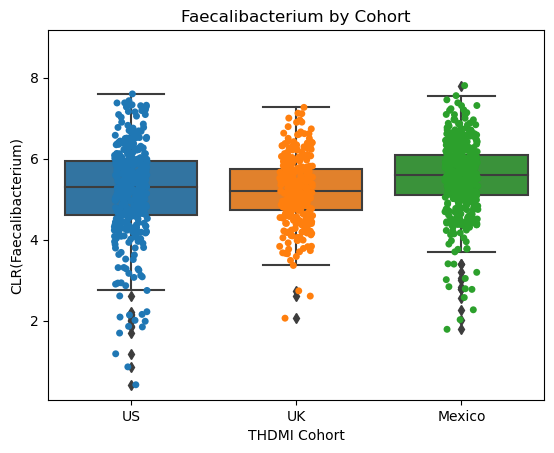

In [16]:
# plt.figure(figsize=(6,8))
sns.stripplot(data=prev_bacteroides_plots, x='thdmi_cohort', y='faecali_clr', hue='thdmi_cohort')
sns.boxplot(data=prev_bacteroides_plots, x='thdmi_cohort', y='faecali_clr')
# Set y-axis limits with a bit more space on top
current_ymin, current_ymax = plt.gca().get_ylim()
plt.ylim(current_ymin, current_ymax + 1) 
plt.ylabel(r'CLR(Faecalibacterium)')
plt.xlabel('THDMI Cohort')
plt.legend([],[], frameon=False)
plt.title(r'Faecalibacterium by Cohort')
plt.savefig('faecalibacterium_clr_by_cohort.pdf')

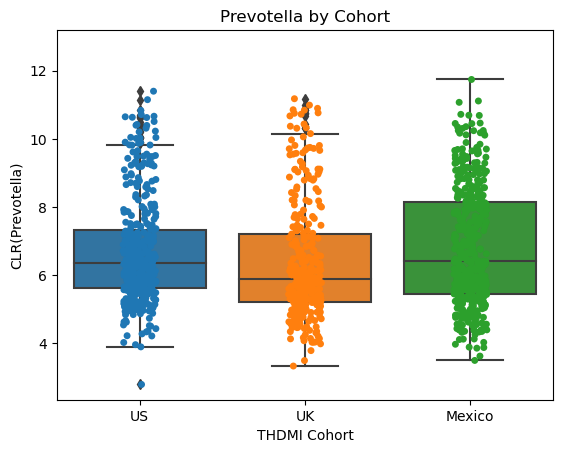

In [17]:
# plt.figure(figsize=(6,8))
sns.stripplot(data=prev_bacteroides_plots, x='thdmi_cohort', y='prevotella_clr', hue='thdmi_cohort')
sns.boxplot(data=prev_bacteroides_plots, x='thdmi_cohort', y='prevotella_clr')
# Set y-axis limits with a bit more space on top
current_ymin, current_ymax = plt.gca().get_ylim()
plt.ylim(current_ymin, current_ymax + 1) 
plt.ylabel(r'CLR(Prevotella)')
plt.xlabel('THDMI Cohort')
plt.legend([],[], frameon=False)
plt.title(r'Prevotella by Cohort')
plt.savefig('prevotella_clr_by_cohort.pdf')

In [18]:
thdmi_md_subset.loc[thdmi_md_subset['prevotella_clr'] > 0].groupby('thdmi_cohort').count()

,Amount_3_Methylhistidine_in_mg,Amount_Acesulfame_Potassium_in_mg,Amount_Added_Sugars__by_Available_Carbohydrate__in_g,Amount_Added_Sugars__by_Total_Sugars__in_g,Amount_Alanine_in_g,Amount_Alcohol_in_g,Amount_Alpha_Carotene__provitamin_A_carotenoid__in_mcg,Amount_Alpha_Tocopherol_in_mg,Amount_Animal_Protein_in_g,Amount_Arginine_in_g,...,specialized_diet_exclude_refined_sugars,types_of_plants_coded,Processed_Calories_Nova_processed_foods_per1000kcal,Processed_Calories_Nova_ultra_processed_foods_per1000kcal,Processed_Calories_Nova_unprocessed_or_minimally_processed_foods_per1000kcal,Processed_Percent_Grams_Nova_ultra_processed_foods,Processed_Percent_Grams_Nova_processed_foods,Processed_Percent_Grams_Nova_unprocessed_or_minimally_processed_foods,faecali_clr,prevotella_clr
thdmi_cohort,,,,,,,,,,,,,,,,,,,,,
Mexico,447,447,447,447,447,447,447,447,447,447,...,460,453,447,447,447,447,447,447,460,460
UK,307,307,307,307,307,307,307,307,307,307,...,307,301,307,307,307,307,307,307,307,307
US,410,410,410,410,410,410,410,410,410,410,...,410,408,407,407,407,407,407,407,410,410


In [19]:
thdmi_md_subset['prevotella_clr'].quantile([0, 0.25, 0.5, 0.75, 1])

0.00     2.795955
0.25     5.451174
0.50     6.251685
0.75     7.701621
1.00    11.740405
Name: prevotella_clr, dtype: float64

In [20]:
thdmi_md_subset.to_csv('log_ratio_foods_analysis.csv')

In [21]:
#run lmer_alpha.R in terminal

In [22]:
out_df = pd.read_csv('log_ratio_analysis.csv', index_col=0)

In [23]:
out_df = out_df.dropna(subset='p_value')

In [24]:
from statsmodels.stats.multitest import multipletests
# Apply FDR correction
_, out_df['P-Value_adj'], _, _ = multipletests(out_df['p_value'].values, alpha=0.05, method='fdr_bh')

In [25]:
out_df[out_df['P-Value_adj'] < .05]

,variable,log_ratio,p_value,marginal_r2,conditional_r2,P-Value_adj
228,Amount_Starch_in_g,prevotella_clr,0.000072,0.031694,0.034475,0.040363


In [30]:
def make_scatterplot(data, yvar, xvar='host_age', cat='region', x_mex=45, y_mex=0.3, x_us=45, y_us=0.2, x_uk=45, y_uk=0.25, xlab=None, ylab=None, title=None, path=None):
    sub_df = data.loc[(data[yvar].notna()) & (data[xvar].notna())]
    
    sns.scatterplot(data=sub_df, x=xvar, y=yvar, hue=cat)
    ax = plt.gca()
    #plt.title("Faith's PD vs " + xvar + ' by Country')
    
    # line of best fit - Mexico 
    x_m = sub_df.loc[sub_df[cat]=='Mexico'][xvar].values
    y_m = sub_df.loc[sub_df[cat]=='Mexico'][yvar].values
    z_m = np.polyfit(x_m, y_m, 1)
    p_m = np.poly1d(z_m)
    plt.plot(x_m,p_m(x_m),"tab:green")
    ax.text(x_mex, y_mex, "r=%0.2f, p=%0.2e" % ss.spearmanr(x_m,y_m), fontsize=10, color='tab:green')
    
    # line of best fit - UK
    xuk = sub_df.loc[sub_df[cat]=='UK'][xvar].values
    yuk = sub_df.loc[sub_df[cat]=='UK'][yvar].values
    zuk = np.polyfit(xuk, yuk, 1)
    puk = np.poly1d(zuk)
    plt.plot(xuk,puk(xuk),"tab:orange")
    ax.text(x_uk, y_uk, "r=%0.2f, p=%0.2e" % ss.spearmanr(xuk,yuk), fontsize=10, color='tab:orange')
    
    # line of best fit - US
    xus = sub_df.loc[sub_df[cat]=='US'][xvar].values
    yus = sub_df.loc[sub_df[cat]=='US'][yvar].values
    zus = np.polyfit(xus, yus, 1)
    pus = np.poly1d(zus)
    plt.plot(xus,pus(xus),"tab:blue")
    ax.text(x_us, y_us, "r=%0.2f, p=%0.2e" % ss.spearmanr(xus,yus), fontsize=10, color='tab:blue')
    
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title) 
    plt.legend(loc='best')
    if path is not None: 
        plt.savefig(path)
    plt.show()

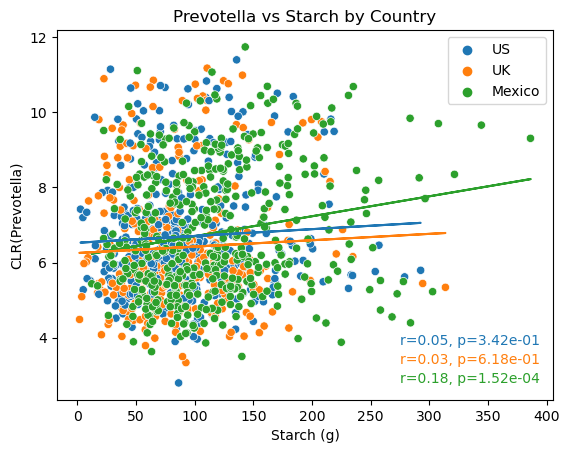

In [31]:
make_scatterplot(data=thdmi_md_subset, xvar='Amount_Starch_in_g', yvar='prevotella_clr', cat='thdmi_cohort', 
                 x_mex = 275, x_us=275, x_uk=275, y_mex=2.8, y_uk=3.3, y_us =3.8, xlab='Starch (g)', 
                 ylab= "CLR(Prevotella)", title='Prevotella vs Starch by Country', 
                 path='scatter_prevotella_clr_starch.pdf')